## First, we would like to create a function that randomly samples the dataset for onsets

# NOTE: Run the next two cells to generate 'onsets' and 'songs', described below. These can be used to test onset detection methods

## second note: change "processed_path" to your own processed path, probably .../Training Data/Processed

## for elliott:

In [13]:
from pathlib import Path
import os

# Generate a list of simplified notes files
processed_path = Path(r'/Users/ewaissbluth/Documents/GitHub/tensor-hero/Training Data/Training Data/Processed')
song_paths = [] # paths to song.ogg files
notes_simplified_paths = [] # paths to corresponding notes_simplified
for p1 in [processed_path / x for x in os.listdir(processed_path)]:
    if '.DS_Store' in str(p1):
        continue
    for p2 in [p1 / x for x in os.listdir(p1)]:
        if '.DS_Store' in str(p2):
            continue
        if 'notes_simplified.npy' in os.listdir(p2):
            song_path = Path(str(p2).replace('Processed', 'Unprocessed')) / 'song.ogg'
            if not os.path.exists(song_path) == True:
                continue
            notes_simplified_paths.append(p2 / 'notes_simplified.npy')
            song_paths.append(song_path)

641


## for Jackie

In [1]:
from pathlib import Path
import os

# Generate a list of simplified notes files
# .../Training Data Onsets
processed_path = Path(r'/Users/cheny/Documents/Training_Data_Onsets/Anti_Hero')

#directory = "C:\\Users\\cheny\\Documents\\Training_Data_Onsets\\Anti_Hero"


song_paths = [] # paths to song.ogg files
notes_simplified_paths = [] # paths to corresponding notes_simplified

for p1 in [processed_path / x for x in os.listdir(processed_path)]:
    if '.DS_Store' in str(p1):
        continue
    #for p2 in [p1 / x for x in os.listdir(p1)]:
    if '.DS_Store' in str(p1):
        continue
    if 'notes_simplified.npy' in os.listdir(p1):
        song_path = p1 / 'song.ogg'
        if not os.path.exists(song_path) == True:
            continue
        notes_simplified_paths.append(p1 / 'notes_simplified.npy')
        song_paths.append(song_path)

In [2]:
notes_simplified_paths

[WindowsPath('/Users/cheny/Documents/Training_Data_Onsets/Anti_Hero/01. Brave This Storm (Miscellany)/notes_simplified.npy'),
 WindowsPath('/Users/cheny/Documents/Training_Data_Onsets/Anti_Hero/01. Broken Soul (Chezy)/notes_simplified.npy'),
 WindowsPath('/Users/cheny/Documents/Training_Data_Onsets/Anti_Hero/01. Human Disaster (Chezy)/notes_simplified.npy'),
 WindowsPath('/Users/cheny/Documents/Training_Data_Onsets/Anti_Hero/01. The Primeval Dark (DigitalSquirrel)/notes_simplified.npy'),
 WindowsPath('/Users/cheny/Documents/Training_Data_Onsets/Anti_Hero/02. Cauterizer (Chezy)/notes_simplified.npy'),
 WindowsPath('/Users/cheny/Documents/Training_Data_Onsets/Anti_Hero/02. Sweetest Poison (Chezy)/notes_simplified.npy'),
 WindowsPath('/Users/cheny/Documents/Training_Data_Onsets/Anti_Hero/03. Pseudo Self (Chezy)/notes_simplified.npy'),
 WindowsPath('/Users/cheny/Documents/Training_Data_Onsets/Anti_Hero/03. Revelation (DigitalSquirrel)/notes_simplified.npy'),
 WindowsPath('/Users/cheny/Docu

In [3]:
import random
import numpy as np
import librosa
import math
import pickle
from tqdm import tqdm

# Select 20 songs at random, from each song, select one 60 second slice
subset_idx = random.sample([x for x in range(len(song_paths))], 20)
subset_idx.sort()

# Define empty lists for the songs and the onsets
# songs = [<numpy array song 1>, <numpy array song 2> ...]
# onsets = [<onset times song 1>, <onset times song 2> ...]
songs = []
onsets = []

# Load the songs and the notes arrays one at a time
for idx in tqdm(subset_idx):
    # Load the song
    y, sr = librosa.load(song_paths[idx])
    
    # resample the song if it isn't sr=22050 (for consistent sizing)
    if not sr == 22050:
        y = librosa.resample(y, sr, 22050)
        sr = 22050
    
    #source seperation
    y_harmonic, y_percussive = librosa.effects.hpss(y, margin=2.0)
    
    # Load notes
    notes = np.load(notes_simplified_paths[idx])
    # Cut off the appended silence from the notes
    notes = notes[7:-7]

    # Choose a random 60 second subset
    song_len_in_seconds = math.floor(y_harmonic.shape[0]/sr)
    random_point = random.randint(0, song_len_in_seconds-60)

    # slice the song and the notes
    subsong = y_harmonic[random_point*sr:(random_point+60)*sr]
    subnotes = notes[random_point*100:(random_point+60)*100]

    # Append the subsong to the array
    songs.append(subsong)

    # Get onsets from notes
    notes_times = np.where(subsong > 0)[0] / 100

    # Append onsets to array
    onsets.append(notes_times)

# Save songs and onsets
with open('onsets.pkl', 'wb') as f:
    pickle.dump(onsets, f)
f.close()
with open('songs.pkl', 'wb') as f:
    pickle.dump(songs, f)
f.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [07:15<00:00, 21.78s/it]


In [4]:
# First, we load onsets and song segments. Recall, "onsets" contains
# ground truth onsets that we calculated from simplified_notes.npy
# songs contains numpy arrays of song waveforms.
with open('onsets.pkl', 'rb') as f:
    onsets = pickle.load(f)
f.close()
with open('songs.pkl', 'rb') as f:
    songs = pickle.load(f)
f.close()

## Next, we would like to define the skeleton of some code that can be used to evaluate the different onset detection methods

In [54]:
len(songs)

20

In [5]:
#already the time
onsets[0]

array([2.300000e-01, 2.400000e-01, 2.500000e-01, ..., 1.322937e+04,
       1.322938e+04, 1.322999e+04])

In [42]:
#
songs[1]

array([ 0.07007247,  0.0323992 ,  0.02576423, ...,  0.11923642,
        0.04253003, -0.06956693], dtype=float32)

In [92]:
S0 = np.abs(librosa.stft(y=songs[0]))

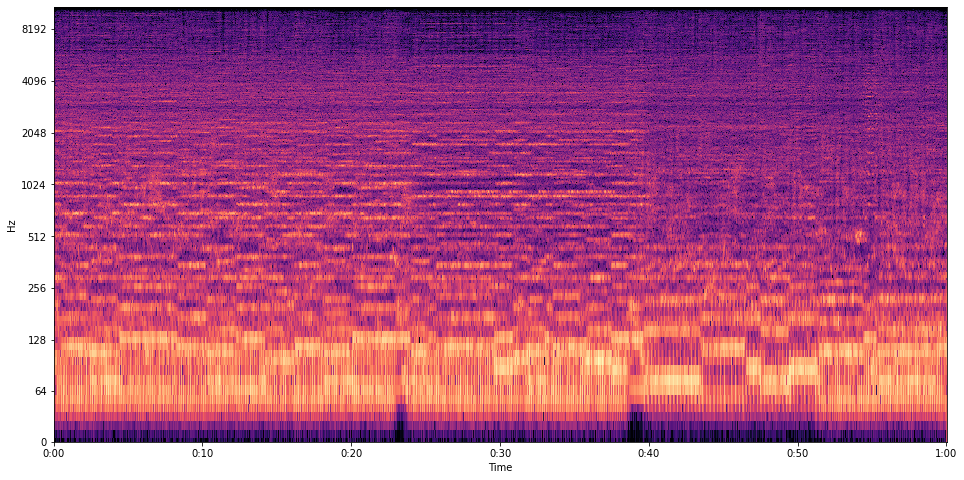

In [93]:
librosa.display.specshow(librosa.amplitude_to_db(S0, ref=np.max),
                         y_axis='log', x_axis='time')

# Onset Time Functions

In [7]:
import mir_eval
import librosa
import pandas as pd
import IPython.display as ipd
from glob import glob
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline 
import librosa
from librosa import display

In [8]:
## Matplotlib
plt.rc("figure", figsize=(16, 8))

In [78]:
#tuning parameters
SR = 22050
HOP_LEN = 512

In [82]:
nfft = 2048                              # length of the FFT window: defines the number of bins used for dividing the window into equal strips, or bins. Hence, a bin is a spectrum sample , and defines the frequency resolution of the window. By default : N (Bins) = FFT Size/2
overlap = 0.5                            # Hop overlap percentage
hop_length = int(nfft * (1 - overlap))   # Number of samples between successive frames(CQT col)

In [83]:
hop_length

1024

In [84]:
"""
Parameters:

harmonic: song file after the source seperation
sr: global variable
hop_len: global variable 
backtrack: 
true_note: onset file tranlate in onset time formate 

Out:
f: f-score -> f_measure, precision, recall
onset_times: onset time from the model

"""
def simple_onset(harmonic, sr, hop_len, backtrack, true_note):
    
    onset_frame_backtrack = librosa.onset.onset_detect(harmonic, sr = sr, hop_length = hop_len, backtrack=backtrack)
    onset_times = librosa.frames_to_time(onset_frame_backtrack)
    
    f = mir_eval.onset.f_measure(true_note, onset_times)
    
    return f, onset_times

In [91]:
simple_onset(songs[0], SR, 18, True, onsets[0])

((0.0015961571535901466, 0.7216916780354706, 0.0007989621044269146),
 array([1.30031746e+00, 2.34521542e+00, 4.52789116e+00, 6.03718821e+00,
        8.08054422e+00, 9.52018141e+00, 1.18653968e+01, 1.32353741e+01,
        1.46053515e+01, 1.63236281e+01, 1.82973243e+01, 2.16642177e+01,
        2.53794104e+01, 2.72137868e+01, 3.05110204e+01, 3.22989569e+01,
        3.68036281e+01, 4.31194558e+01, 4.45358730e+01, 4.70204082e+01,
        4.97603628e+01, 5.15947392e+01, 5.33130159e+01, 5.45668934e+01,
        5.68192290e+01, 5.84214059e+01, 6.04183220e+01, 6.37619955e+01,
        6.49926531e+01, 6.74771882e+01, 6.85685261e+01, 7.04725624e+01,
        7.38858957e+01, 7.68580499e+01, 8.08751020e+01, 8.45902948e+01,
        8.64711111e+01, 8.81197279e+01, 9.15330612e+01, 9.28101587e+01,
        9.67343311e+01, 9.98458050e+01, 1.02446440e+02, 1.05650794e+02,
        1.06579592e+02, 1.09064127e+02, 1.12314921e+02, 1.13754558e+02,
        1.18770068e+02, 1.23088980e+02, 1.24389297e+02, 1.26548753e

In [65]:
import sklearn
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV

In [66]:
X_train = songs[0]
y_train = onsets[0]
X_test = songs[1]
y_test = onsets[1]

In [ ]:
hop_len = [10, 1, 10, 100]

In [67]:
# defining parameter range 
param_grid = {'hop_len': [0.1, 1, 10, 100],  
              'sr': [22050], 
              'backtrack': [True, False]}  

model - 

grid = GridSearchCV(simple_onset(), param_grid, scoring = 'f1', refit = True, verbose = 3,n_jobs=-1) 
   
# fitting the model for grid search 
grid.fit(X_train, y_train) 
 
# print best parameter after tuning 
print(grid.best_params_) 
grid_predictions = grid.predict(X_test) 
   
# print classification report 
print(classification_report(y_test, grid_predictions)) 

TypeError: simple_onset() missing 5 required positional arguments: 'harmonic', 'sr', 'hop_len', 'backtrack', and 'true_note'

In [32]:
"""
Using a onset Strength envelope on the onset detection and onset backtrack

Parameter:

harmonic: song file after the source seperation
sr: global variable
hop_len: global variable 
backtrack: 
true_note: onset file tranlate in onset time formate 

Out:
f: f-score
onset_times: onset time from the model

"""

def onset_envelop(harmonic, sr, hop_len, backtrack, true_note):
    #'Onset strength'
    oenv = librosa.onset.onset_strength(y=harmonic, sr=sr) 
    #times = librosa.times_like(oenv)
    
    onset_raw = librosa.onset.onset_detect(onset_envelope = oenv, hop_length = hop_len, backtrack=backtrack)
    onset_bt = librosa.onset.onset_backtrack(onset_raw, oenv)
    
    onset_times = librosa.frames_to_time(onset_bt)
    
    f = mir_eval.onset.f_measure(true_note, onset_times)
    
    return f, onset_times

In [38]:
onset_envelop(songs[0], SR, 1024, True, onsets[0])

((0.0014846981038413548, 0.754601226993865, 0.000743080066877206),
 array([4.64399093e-02, 9.28798186e-02, 9.28798186e-02, 1.62539683e-01,
        3.48299320e-01, 4.64399093e-01, 5.34058957e-01, 6.50158730e-01,
        9.05578231e-01, 9.75238095e-01, 1.13777778e+00, 1.27709751e+00,
        1.48607710e+00, 1.57895692e+00, 1.76471655e+00, 1.81115646e+00,
        1.92725624e+00, 1.92725624e+00, 1.99691610e+00, 2.11301587e+00,
        2.25233560e+00, 2.29877551e+00, 2.36843537e+00, 2.48453515e+00,
        2.60063492e+00, 2.67029478e+00, 2.85605442e+00, 2.97215420e+00,
        3.08825397e+00, 3.22757370e+00, 3.34367347e+00, 3.52943311e+00,
        3.71519274e+00, 3.76163265e+00, 3.80807256e+00, 3.97061224e+00,
        4.01705215e+00, 4.17959184e+00, 4.38857143e+00, 4.52789116e+00,
        4.73687075e+00, 4.87619048e+00, 4.87619048e+00, 4.99229025e+00,
        5.22448980e+00, 5.52634921e+00, 5.52634921e+00, 5.78176871e+00,
        5.87464853e+00, 6.15328798e+00, 6.19972789e+00, 6.64090703e+0

In [60]:
"""

The Short-time Fourier transform represents a signal in the time-frequency domain by 
computing discrete Fourier transforms (DFT) over short overlapping windows.

Using a onset Strength envelope on the onset detection and onset backtrack

Parameter:

harmonic: song file after the source seperation
sr: global variable
hop_len: global variable 
backtrack: 
true_note: onset file tranlate in onset time formate 

Out:
f: f-score
onset_times: onset time from the model

"""

def onset_rms(harmonic, sr, hop_len, backtrack, true_note):
    
    S = np.abs(librosa.stft(y=harmonic))
    rms = librosa.feature.rms(S=S)
    
    oenv = librosa.onset.onset_strength(y=harmonic, sr=sr)
    #times = librosa.times_like(oenv)
    
   
    onset_raw = librosa.onset.onset_detect(onset_envelope =oenv,  hop_length = hop_len, backtrack=backtrack)
    onset_bt_rms = librosa.onset.onset_backtrack(onset_raw, rms[0])
    
    onset_times = librosa.frames_to_time(onset_raw)
    
    f = mir_eval.onset.f_measure(true_note, onset_times)
    
    return f, onset_times
    

## Average F score

In [61]:
# PSEUDOCODE:
# Next, we iterate through onsets and songs

sum_f_1 = 0.0
sum_f_2 = 0.0
sum_f_3 = 0.0

for i in range(len(onsets)):
    reference_onset = onsets[i]
    audio = songs[i]
    
    f1, onset_time_1 = simple_onset(audio, SR, HOP_LEN, True, reference_onset)
    sum_f_1 += f1[0]
    
    
    f2, onset_time_2 = onset_envelop(audio, SR, HOP_LEN, True, reference_onset)
    sum_f_2 += f2[0]
    
    f3, onset_time_3 = onset_rms(audio, SR, HOP_LEN, True, reference_onset)
    sum_f_3 += f3[0]

    # DO ANALYSIS ON EACH SONG SEGMENT
    # REPORT THE AVERAGE F1 SCORE OVER ALL 20 SEGMENTS FOR EACH
    # HYPERPARAMETER / PREPROCESSING METHOD

    
ave_f_1 = sum_f_1 / len(onsets)
ave_f_2 = sum_f_2 / len(onsets)
ave_f_3 = sum_f_3 / len(onsets)

In [62]:
ave_f_1

0.0007061666971727154

In [63]:
ave_f_2

0.0007061666971727154

In [64]:
ave_f_3

0.0007061666971727154